In [8]:
"""
resource_grid.py – Bit generation, 16‑QAM modulation and resource‑grid mapping
for the PUSCH mini‑project in 3GPP TDL‑B channel simulation.

Author: ChatGPT (o3)
-------------------------------------------------------------------------------
This module automates three steps required by Section II‑1 of the pdf spec fileciteturn2file1:

1. Generate a random bit stream of shape **(3276, 13, 4)** where the last axis
   contains the 4 bits that form one 16‑QAM symbol.
2. Map the bits to 16‑QAM symbols using the Gray code specified by 3GPP
   TS 38.211 §5.1.3 (normalised to unit average power, i.e. /√10).
3. Insert those symbols into a 3276 × 14 resource grid, filling *all* columns
   except the DM‑RS column #3.  The DM‑RS vector is read from the Excel file
   «l1_mini_project_ce_eq_dmrs_data.xlsx» that accompanies the assignment and
   occupies the entire column 3 (time symbol index 3).

Visual order (top‑to‑bottom, then left‑to‑right) matches the spec:

   D0,0 → D1,0 → … → D3276,0 → D0,1 → D1,1 → … → D3276,13
                           ^col=0                     ^col=13

DM‑RS sits at (all_subcarriers, col=3).

Usage example
-------------

>>> from resource_grid import ResourceGridBuilder
>>> rg = ResourceGridBuilder(seed=2025)
>>> bits     = rg.random_bits()              # (3276,13,4)
>>> symbols  = rg.qam16_gray(bits)           # (3276,13)
>>> dmrs_vec = rg.load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx')
>>> grid     = rg.build_grid(symbols, dmrs_vec)
>>> grid.shape
(3276, 14)

-------------------------------------------------------------------------------
"""
from __future__ import annotations
import math
from pathlib import Path

import numpy as np
import pandas as pd


class ResourceGridBuilder:
    """Helper class that encapsulates bit–>symbol–>grid mapping for PUSCH."""

    #: Column index reserved for demodulation reference signals (DMRS)
    DMRS_COL: int = 3

    def __init__(self,
                 n_subcarriers: int = 3276,
                 n_data_sym: int = 13,
                 dmrs_col: int | None = None,
                 seed: int | None = None) -> None:
        self.N_SC = n_subcarriers
        self.N_SYM = n_data_sym                     # data symbols per RB (time)
        self.DMRS_COL = dmrs_col if dmrs_col is not None else self.DMRS_COL
        # data columns are 0‥13 except dmrs_col
        self._data_cols = [c for c in range(14) if c != self.DMRS_COL]
        if len(self._data_cols) != self.N_SYM:
            raise ValueError("N_SYM must equal 13 when DMRS at col 3.")
        self.rng = np.random.default_rng(seed)

    # --------------------------------------------------------------------- #
    #   1) Bit generation
    # --------------------------------------------------------------------- #
    def random_bits(self, m=4) -> np.ndarray:
        """Return random {0,1} bits with shape (N_SC, N_SYM, m)."""
        return self.rng.integers(0, 2,
                                 size=(self.N_SC, self.N_SYM, m),
                                 dtype=np.uint8)

    # # --------------------------------------------------------------------- #
    # #   2) 16‑QAM Gray‑coded modulation
    # # --------------------------------------------------------------------- #
    # @staticmethod
    # def _gray_levels(b_msb: np.ndarray, b_lsb: np.ndarray) -> np.ndarray:
    #     """Map 2‑bit Gray pair → amplitude in {+3,+1,‑1,‑3}."""
    #     # Gray table 00→+3, 01→+1, 11→‑1, 10→‑3  (index = msb*2 + lsb)
    #     table = np.array([3, 1, -3, -1], dtype=np.int8)
    #     idx = (b_msb << 1) | b_lsb
    #     return table[idx]

    # def qam16_gray(self, bits: np.ndarray) -> np.ndarray:
    #     """Convert bit tensor (...,4) to complex 16‑QAM symbols (...).

    #     Gray mapping per 3GPP TS 38.211 §5.1.3, normalised so that
    #     E[|s|²] = 1 ⇒ divide by √10.
    #     """
    #     if bits.shape[-1] != 4:
    #         raise ValueError("Last axis must have length 4 (b0..b3).")

    #     b = bits.reshape(-1, 4)
    #     I = self._gray_levels(b[:, 0], b[:, 1])
    #     Q = self._gray_levels(b[:, 2], b[:, 3])
    #     sym = (I + 1j * Q) / math.sqrt(10.0)
    #     return sym.reshape(bits.shape[:-1])
    
    # --------------------------------------------------------------------- #
    #   2) 16‑QAM Gray‑coded modulation (3GPP compliant)
    # --------------------------------------------------------------------- #
    @staticmethod
    def qam16_gray(bits: np.ndarray) -> np.ndarray:
        """Convert bit tensor (...,4) → complex 16‑QAM symbols (...).

        Mapping aligns with 3GPP TS 38.211 §5.1.3 (see the provided table):

            d(i) = 1/√10 · [(1‑2b0)(1+2b2) + j(1‑2b1)(1+2b3)]

        The average symbol power is thus **1**.
        """
        if bits.shape[-1] != 4:
            raise ValueError("Last axis must have length 4 (b0..b3).")

        b = bits.astype(np.int8)  # ensure signed arithmetic
        I = (1 - 2 * b[..., 0]) * (1 + 2 * b[..., 2])
        Q = (1 - 2 * b[..., 1]) * (1 + 2 * b[..., 3])
        sym = (I + 1j * Q) / math.sqrt(10.0)
        return sym
    @staticmethod
    def qam16_gray_demod(symbols: np.ndarray) -> np.ndarray:
        """
        Hard-demodulate complex 16-QAM Gray symbols -> bits (...,4).

        Inverse của:
            d = 1/√10 * [(1-2b0)(1+2b2) + j(1-2b1)(1+2b3)]

        Returns uint8 array với cùng shape như symbols + trailing dim=4.
        """
        # Lấy real và imag, bù scale
        scale = math.sqrt(10.0)
        I = symbols.real * scale
        Q = symbols.imag * scale

        # b0,b1: sign bit (0 nếu ≥0, 1 nếu <0)
        b0 = (I < 0).astype(np.uint8)
        b1 = (Q < 0).astype(np.uint8)

        # b2,b3: magnitude bit (1 nếu |amp|=3, 0 nếu =1)
        # Threshold nằm giữa 1 và 3, tức ≈2
        b2 = (np.abs(I) > 2.0).astype(np.uint8)
        b3 = (np.abs(Q) > 2.0).astype(np.uint8)

        # Stack lại theo thứ tự [b0,b1,b2,b3]
        bits = np.stack([b0, b1, b2, b3], axis=-1)
        return bits
    
    @staticmethod
    def qpsk(bits: np.ndarray) -> np.ndarray:
        """
        Convert bit tensor (...,2) → complex QPSK symbols (...).
        d = 1/√2 * [ (1-2b0) + j(1-2b1) ]
        """
        if bits.shape[-1] != 2:
            raise ValueError("Last axis must have length 2 (b0..b1) for QPSK.")
        b = bits.astype(np.int8)
        I = (1 - 2*b[..., 0])
        Q = (1 - 2*b[..., 1])
        return (I + 1j*Q) / math.sqrt(2)

    @staticmethod
    def qpsk_demod(symbols: np.ndarray) -> np.ndarray:
        """
        Hard-demodulate complex QPSK symbols → bits (...,2).
        b0 = 0 if Re ≥ 0 else 1
        b1 = 0 if Im ≥ 0 else 1
        """
        I = symbols.real
        Q = symbols.imag
        b0 = (I < 0).astype(np.uint8)
        b1 = (Q < 0).astype(np.uint8)
        return np.stack([b0, b1], axis=-1)

    @staticmethod
    def qam64_gray(bits: np.ndarray) -> np.ndarray:
        """
        64-QAM Gray-coded per 3GPP TS 38.211 §5.1.3:
        d = 1/√42 * { (1−2b0)[4−(1−2b2)[2−(1−2b4)]] 
                      + j·(1−2b1)[4−(1−2b3)[2−(1−2b5)]] }
        """
        if bits.shape[-1] != 6:
            raise ValueError("Last axis must have length 6 for 64-QAM.")
        b = bits.astype(np.int8)
        # lấy các bit

        I = (1 - 2*b[...,0])*(4 - (1 - 2*b[...,2])*(2 - (1 - 2*b[...,4])))
        Q = (1 - 2*b[...,1])*(4 - (1 - 2*b[...,3])*(2 - (1 - 2*b[...,5])))

        return (I + 1j*Q) / math.sqrt(42.0)

    @staticmethod
    def qam64_gray_demod(symbols: np.ndarray) -> np.ndarray:
        """
        Hard-demodulate 64-QAM Gray symbols → bits (...,6),
        inverse của công thức trên.
        """
        scale = math.sqrt(42.0)
        I = symbols.real * scale
        Q = symbols.imag * scale
        absI = np.abs(I)
        absQ = np.abs(Q)

        # bit dấu
        b0 = (I < 0).astype(np.uint8)
        b1 = (Q < 0).astype(np.uint8)
        # bit middle: 0 nếu |x|∈{1,3}, 1 nếu ∈{5,7}
        b2 = (absI > 3).astype(np.uint8)
        b3 = (absQ > 3).astype(np.uint8)
        # bit LSB: dựa vào giá trị còn lại
        # nếu middle=0: LSB=1 khi |x|==1; nếu middle=1: LSB=1 khi |x|==7
        b4 = np.where(b2==0, (absI==1), (absI==7)).astype(np.uint8)
        b5 = np.where(b3==0, (absQ==1), (absQ==7)).astype(np.uint8)

        return np.stack([b0, b1, b2, b3, b4, b5], axis=-1)
    # --------------------------------------------------------------------- #
    #   3) DM‑RS loader
    # --------------------------------------------------------------------- #
    @staticmethod
    def _parse_complex(cell) -> complex:
        """Convert strings like '1+1i', '-1-1i', '0' into Python complex."""
        s = str(cell).strip().replace('i', 'j')
        try:
            return complex(s)
        except ValueError as err:
            raise ValueError(f"Cannot parse DMRS cell '{cell}'.") from err

    def load_dmrs(self, xlsx_path: str | Path,
                  expect_len: int | None = None) -> np.ndarray:
        """Read DM‑RS column vector from Excel (one complex per row)."""
        xlsx_path = Path(xlsx_path)
        if not xlsx_path.exists():
            raise FileNotFoundError(xlsx_path)
        # Read without header – 3GPP helper sheet is usually single column
        df = pd.read_excel(xlsx_path, header=None, engine='openpyxl')
        dmrs = df.iloc[:, 0].apply(self._parse_complex).to_numpy()
        if expect_len is None:
            expect_len = self.N_SC
        if dmrs.size != expect_len:
            raise ValueError(f"DMRS length {dmrs.size} ≠ expected {expect_len}.")
        return dmrs

    # --------------------------------------------------------------------- #
    #   4) Resource‑grid constructor
    # --------------------------------------------------------------------- #
    def build_grid(self,
                   data_symbols: np.ndarray,
                   dmrs_vec: np.ndarray) -> np.ndarray:
        """Return 3276×14 grid with data and DM‑RS populated."""
        if data_symbols.shape != (self.N_SC, self.N_SYM):
            raise ValueError("data_symbols must have shape (N_SC, N_SYM).")
        if dmrs_vec.shape[0] != self.N_SC:
            raise ValueError("dmrs_vec length mismatches N_SC.")

        grid = np.zeros((self.N_SC, 14), dtype=complex)
        # Insert data columns
        for j, col in enumerate(self._data_cols):
            grid[:, col] = data_symbols[:, j]
        # Insert DM‑RS
        grid[:, self.DMRS_COL] = dmrs_vec
        return grid

In [9]:
"""ofdm.py – 4096‑IFFT NR OFDM modulator (15 kHz SCS, normal CP)
-------------------------------------------------------------------
Converts a frequency‑domain resource‑grid of shape (N_sub=3276, N_sym=14) into a
single time‑domain slot of **61 440 complex samples**. The CP pattern follows
3GPP NR normal‑CP at 15 kHz Subcarrier Spacing (SCS = 15 kHz):

    * Symbol 0 and 7 : CP = 320 samples
    * Others         : CP = 288 samples

With N_FFT = 4096, the overall sample rate is 61.44 MHz, so 61 440 samples
correspond to exactly one 1‑ms slot (14 OFDM symbols).

Example
-------
>>> from resource_grid import ResourceGridBuilder
>>> from ofdm import ofdm_modulate
>>> rg = ResourceGridBuilder(seed=1)
>>> grid = rg.build_grid(rg.qam16_gray(rg.random_bits()), rg.load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx'))
>>> tx = ofdm_modulate(grid)           # (61440,)
>>> assert tx.shape[0] == 61_440

Notes
-----
* Active sub‑carriers (3276) are **DC‑centred** in the IFFT input:
    – Negative frequencies (‑1638..‑1) occupy bins 0…1637 after ifftshift.
    – Positive frequencies (+1..+1638) occupy bins 4096‑1638…4095.
* The function is stateless; for fading simulations you may call it repeatedly.
"""

from __future__ import annotations
import numpy as np

# -----------------------------------------------------------------------------
N_FFT = 4096  # fixed as derived: 14*N_FFT + sum(CP) = 61 440
_CP_LEN = [320 if s in (0, 7) else 288 for s in range(14)]
_SUM_CP = sum(_CP_LEN)  # 4 096 samples
_TOTAL_LEN = 14 * N_FFT + _SUM_CP  # 61 440 samples

__all__ = [
    "ofdm_modulate",
    "N_FFT",
    "CP_LENGTHS",
    "TOTAL_SAMPLES",
]

CP_LENGTHS = tuple(_CP_LEN)
TOTAL_SAMPLES = _TOTAL_LEN

def _map_subcarriers(sym_freq: np.ndarray, n_fft: int = N_FFT) -> np.ndarray:
    """Embed a *contiguous DC‑centred* sub‑band into an *n_fft* vector.

    Parameters
    ----------
    sym_freq : (3276,) complex ndarray
        Active sub‑carrier values (lowest index → -1638, highest → +1637).
    n_fft : int, default 4096
        Size of IFFT.

    Returns
    -------
    vec : (n_fft,) complex ndarray
        Frequency bins, *ifftshifted* (i.e., ready for np.fft.ifft).
    """
    k = sym_freq.shape[0]
    if k != 3276:
        raise ValueError("sym_freq must have 3276 sub‑carriers (got %d)" % k)
    half = k // 2  # 1638
    vec_shift = np.zeros(n_fft, dtype=sym_freq.dtype)
    center = n_fft // 2  # 2048
    start = center - half  # 2048‑1638 = 410
    vec_shift[start : start + k] = sym_freq  # contiguous placement around DC
    # Convert to natural order for IFFT: ifftshift
    return np.fft.ifftshift(vec_shift)

def ofdm_modulate(grid: np.ndarray, *, n_fft: int = N_FFT, cp_lengths = CP_LENGTHS) -> np.ndarray:
    """OFDM‑modulate a 3276×14 grid → 61 440‑sample time slot.

    Parameters
    ----------
    grid : ndarray of complex64/128, shape (3276, 14)
        Frequency‑domain resource grid (one column per OFDM symbol).
    n_fft : int, optional
        IFFT size (default 4096).
    cp_lengths : Sequence[int], optional
        CP length for each of 14 symbols (default per 3GPP normal‑CP).

    Returns
    -------
    tx : (61 440,) complex ndarray
        Time‑domain slot (CP | data | CP | data | …).
    """
    if grid.shape != (3276, 14):
        raise ValueError("grid must be (3276, 14), got %s" % (grid.shape,))
    if len(cp_lengths) != 14:
        raise ValueError("cp_lengths must list 14 ints (one per symbol)")

    symbols_td = []  # build list then concat for speed
    for s in range(14):
        vec = _map_subcarriers(grid[:, s], n_fft)
        time_sym = np.fft.ifft(vec)  # numpy divides by N_FFT internally
        cp = time_sym[-cp_lengths[s] :]
        symbols_td.append(cp)
        symbols_td.append(time_sym)

    tx = np.concatenate(symbols_td)
    if tx.size != TOTAL_SAMPLES:
        raise RuntimeError("Generated %d samples, expected %d" % (tx.size, TOTAL_SAMPLES))
    return N_FFT*tx



In [10]:
#!/usr/bin/env python3
"""
channel_apply.py – From-scratch demo: apply 3GPP TDL‑B (100 ns) fading + 20 dB AWGN
=================================================================================
This standalone script:
  1) Implements a 12‑tap TDL‑B channel (100 ns) with 25 Hz Doppler (Jakes).
  2) Convolves an input complex baseband signal `x` through the time‑varying channel.
  3) Adds AWGN to achieve a target SNR (20 dB by default).

Usage:
    python channel_apply.py [--input tx.npy] [--snr 20] [--seed 42]

If `--input` is omitted, a random QPSK-like signal is generated.

"""
import argparse
import math
import numpy as np
from numpy.random import default_rng

# --- TDLB100 channel class ------------------------------------------------
class TDLB100:
    """Time‑varying FIR for 3GPP TDL‑B (100 ns) with Jakes Doppler fading."""
    _POW_DB = np.array([0.0, -2.2, -0.6, -0.6, -0.3, -1.2,
                        -5.9, -2.2, -0.8, -6.3, -7.5, -7.1])
    _DEL_NS = np.array([0.0, 10.0, 20.0, 30.0, 35.0, 45.0,
                        55.0, 120.0, 170.0, 245.0, 330.0, 480.0])

    def __init__(self, fs, fd=25.0, seed=None, M=16):
        self.fs = float(fs)
        self.fd = float(fd)
        self.rng = default_rng(seed)
        # linear tap powers & sample delays
        self.p_lin = 10 ** (self._POW_DB / 10)
        self.del_samp = np.round(self._DEL_NS * 1e-9 * self.fs).astype(int)
        self.ntaps = len(self.p_lin)
        self.tau_max = int(self.del_samp.max())
        # prepare Jakes faders for each tap
        k = np.arange(1, M+1)
        alpha = math.pi*(k-0.5)/M
        omega = 2*math.pi*self.fd*np.cos(alpha)
        phi = self.rng.uniform(0,2*math.pi,size=(self.ntaps,M))
        self.faders = (omega, phi, 2.0/M)

    def cir(self, num, start=0):
        """Generate CIR matrix shape (ntaps, num) complex."""
        omega, phi, scale2 = self.faders
        t = (start + np.arange(num)) / self.fs
        # sum-of-sinusoids per tap
        i = np.zeros((self.ntaps,num),dtype=float)
        q = np.zeros((self.ntaps,num),dtype=float)
        for tap in range(self.ntaps):
            pha = omega[:,None]*t + phi[tap][:,None]
            i[tap] = np.sqrt(scale2) * np.sum(np.cos(pha),axis=0)
            q[tap] = np.sqrt(scale2) * np.sum(np.sin(pha),axis=0)
        h = (i+1j*q).astype(np.complex64)
        # scale by tap power
        h *= np.sqrt(self.p_lin)[:,None]
        return h
    
    def apply_channel(self, x):
        """Filter x through channel + AWGN, return y same shape."""
        if x.ndim!=1 or not np.iscomplexobj(x):
            raise ValueError("x must be 1-D complex array")
        N = x.size
        # time-varying convolution
        y = np.zeros(N+self.tau_max, dtype=np.complex64)
        h = self.cir(N)
        for k,d in enumerate(self.del_samp):
            y[d:d+N] += h[k] * x
        y = y[:N]
        # normalized
        y = y / np.sqrt(np.mean(np.abs(y)**2)) * np.sqrt(np.mean(np.abs(x)**2))
        return y
    
    def get_noise(self, x, snr_db):
        N = x.size
        snr_lin = 10**(snr_db/10)
        noise_var = (np.abs(x)**2).mean()/snr_lin
        noise = (math.sqrt(noise_var / 2) * (self.rng.standard_normal(N) + 1j * self.rng.standard_normal(N))).astype(np.complex64)
        return noise



In [11]:
def ofdm_demodulate(rx_slot: np.ndarray) -> np.ndarray:
    """
    Nhận 1 slot time-domain (len = 61440) --> trả về lưới freq-domain (3276,14)
    """
    if rx_slot.size != TOTAL_SAMPLES:
        raise ValueError(f"rx_slot phải có độ dài {TOTAL_SAMPLES}")
    N_SC = 3276
    grid_rx = np.zeros((N_SC, 14), dtype=np.complex64)
    idx = 0
    for s, cp_len in enumerate(CP_LENGTHS):
        # bỏ qua CP
        idx += cp_len
        # lấy symbol time-domain
        sym_td = rx_slot[idx : idx + N_FFT]
        idx += N_FFT
        # FFT và bù scale
        bins = np.fft.fft(sym_td) / N_FFT
        # dịch ngược sub-carrier về vị trí DC-centered
        bins_shifted = np.fft.fftshift(bins)
        # trích 3276 sub-carrier quanh DC
        half = N_SC // 2                     # 1638
        center = N_FFT // 2                  # 2048
        start = center - half                # 2048-1638 = 410
        grid_rx[:, s] = bins_shifted[start:start+N_SC]
    return grid_rx

def qam16_gray_hard(symbols: np.ndarray) -> np.ndarray:
    """
    Giải điều chế hard-bit 16-QAM Gray.
    Input: symbols.shape = (...), complex
    Output: bits.shape = (...,4), dtype=uint8
    """
    # ngưỡng giữa ±1 và ±3 (cùng chia √10)
    thresh = 2.0 / np.sqrt(10.0)
    I = symbols.real
    Q = symbols.imag

    # MSB: sign, LSB: magnitude
    b0 = (I < 0).astype(np.uint8)
    b1 = (Q < 0).astype(np.uint8)
    b2 = (np.abs(I) > thresh).astype(np.uint8)
    b3 = (np.abs(Q) > thresh).astype(np.uint8)

    # kết hợp về cuối cùng
    bits = np.stack([b0, b1, b2, b3], axis=-1)
    return bits



In [12]:
rg = ResourceGridBuilder(seed=42)
bits     = rg.random_bits()                          # (3276,13,4)
symbols  = rg.qam16_gray(bits)                       # (3276,13)
dmrs_vec = rg.load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx')
grid     = rg.build_grid(symbols, dmrs_vec)          # (3276,14)
# grid: (3276, 14) complex (đã gồm DMRS)
tx_slot = ofdm_modulate(grid)          # (61440,) complex64
seed = 123
N = 61440  # one NR slot at 15kHz SCS
rng = default_rng(seed)
x = (rng.standard_normal(N) + 1j*rng.standard_normal(N)) / np.sqrt(2)
# apply channel
fs = 61.44e6
ch = TDLB100(fs, fd=25.0, seed=seed)
y = ch.apply_channel(tx_slot)
n = ch.get_noise(y, snr_db=0.)
# === Example sử dụng ===
# y là tín hiệu đầu ra từ channel_apply.py
# from channel_apply import y
grid_est = ofdm_demodulate(y+n)          # (3276,14)
# Loại bỏ cột DM-RS (col=3) nếu chỉ cần data
data_grid = np.delete(grid_est, 3, axis=1)  # (3276,13)
bits_rx   = qam16_gray_hard(data_grid)      # (3276,13,4)

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assume `z` is the provided complex-valued NumPy array of shape (3276, 13)
# # For demonstration, here’s a placeholder. Replace with your actual array.
# # z = np.load('your_array.npy')

# x_freq = np.ones((3276,14), dtype=np.complex64)
# x_time = ofdm_modulate(x_freq)   
# # apply channel
# fs = 61.44e6
# ch = TDLB100(fs, fd=25.0, seed=seed)
# y_time = ch.apply_channel(x_time)
# y_grid = ofdm_demodulate(y_time)
# h_freq = y_grid/x_freq
# h_freq

# # Compute magnitude and phase
# z = h_freq
# magnitude = np.abs(z)
# phase = np.angle(z)

# # Plot magnitude heatmap
# plt.figure()
# plt.imshow(magnitude, aspect='auto')
# plt.colorbar()
# plt.title('Magnitude of Complex Array')
# plt.xlabel('Column Index')
# plt.ylabel('Row Index')

# # Plot phase heatmap
# plt.figure()
# plt.imshow(phase, aspect='auto')
# plt.colorbar()
# plt.title('Phase of Complex Array')
# plt.xlabel('Column Index')
# plt.ylabel('Row Index')

# plt.show()


In [14]:
import numpy as np

def compute_mse(symbols_tx: np.ndarray, symbols_rx: np.ndarray) -> float:
    """Mean Squared Error giữa hai mảng complex cùng shape."""
    diff = symbols_tx - symbols_rx 
    mse = np.mean(np.abs(diff)**2)
    return mse #, mse / np.mean(np.abs(symbols_tx)**2)

def compute_ber(bits_tx: np.ndarray, bits_rx: np.ndarray) -> float:
    """Bit Error Rate giữa hai mảng uint8 shape (...,4)."""
    # so sánh element-wise, chuyển True->1, False->0
    errors = (bits_tx != bits_rx).astype(np.uint8)
    return errors.mean()

# Ví dụ:
ber = compute_ber(bits, bits_rx)
print(f"BER = {ber:.2%}")
mse = compute_mse(symbols, data_grid)
print(f"MSE = {mse:.6e}")

BER = 41.47%
MSE = 1.929782e+00


In [15]:
def build_Rhh_sinc(N_sc, delta_f, tau_max):
    idx  = np.arange(N_sc)
    diff = idx[:, None] - idx[None, :]
    return np.sinc(delta_f * tau_max * diff)

def build_Rhh_exponential(N_sc, delta_f, tau_rms):
    idx = np.arange(N_sc)
    diff = idx[:, None] - idx[None, :]
    # 1/(1 + j*2πΔf τ_rms Δk)
    return 1.0 / (1.0 + 1j*2*np.pi*delta_f*tau_rms*diff)

Rhh = build_Rhh_exponential(12, 15e3, 100e-9)
Rhp = Rhh[:,0::2]
Rpp = Rhh[0::2,0::2]

def ls_est_sparse(rx_grid: np.ndarray,
                               dmrs_tx: np.ndarray,
                               dmrs_col: int = 3,
                               method: str = 'linear') -> np.ndarray:
    """
    LS channel estimate chỉ trên subcarriers chẵn, rồi nội suy/duplicate ra toàn bộ.

    Parameters
    ----------
    rx_grid : ndarray, shape (N_sc, N_sym)
        Lưới freq-domain đã nhận.
    dmrs_tx : ndarray, shape (N_sc,)
        Vector DM-RS đã truyền.
    dmrs_col : int
        Cột DM-RS trong rx_grid.
    method : {'linear', 'nearest'}
        'linear'   => nội suy tuyến tính giữa hai pilot;
        'nearest'  => duplicate nearest neighbor (odd <- even left).

    Returns
    -------
    H_est : ndarray, shape (N_sc,)
        Full channel estimate trên mọi subcarrier.
    """
    N_sc = rx_grid.shape[0]
    No = None
    # 1) Lấy pilot: chỉ subcarrier chẵn
    pilot_idx = np.arange(0, N_sc, 2)
    Y_pilot = rx_grid[pilot_idx, dmrs_col]
    X_pilot = dmrs_tx[pilot_idx]
    H_pilot = Y_pilot / X_pilot

    # 2) Khởi tạo mảng estimate
    H_est = np.empty(N_sc, dtype=complex)

    if method == 'linear':
        # nội suy real và imag riêng
        x = np.arange(N_sc)
        real = np.interp(x, pilot_idx, H_pilot.real)
        imag = np.interp(x, pilot_idx, H_pilot.imag)
        H_est = real + 1j * imag

    elif method == 'nearest':
        # gán pilot
        H_est[pilot_idx] = H_pilot
        # duplicate: mỗi subcarrier lẻ lấy giá trị của subcarrier chẵn bên trái
        H_est[1::2] = H_est[0::2]
    
    elif 'average' in method:
        w = int(method.split('-')[-1])
        # first do nearest-fill      
        
        # # moving-average smoothing (uniform window)
        # if window_size % 2 == 0:
        #     raise ValueError("window_size must be odd")
        
        kernel1 = np.ones(w+1) / (w+1)
        kernel0 = np.ones(w) / (w)
        H_est[0::2] = np.convolve(H_pilot.real, kernel1, mode='same') + 1j * np.convolve(H_pilot.imag, kernel1, mode='same')
        H_est[1::2] = np.convolve(H_pilot.real, kernel0, mode='same') + 1j * np.convolve(H_pilot.imag, kernel0, mode='same')

        No = (np.abs(Y_pilot - H_est[0::2]*X_pilot)**2).mean()
    elif 'wiener1step' in method:
        for i in range(0, N_sc, 12):
            H_est[i:i+12] = Rhp @ np.linalg.inv(Rpp + 1e-2*np.eye(6)) @ H_pilot[i//2:i//2+6]
    elif 'wiener2step' in method:
        for i in range(0, N_sc, 12):
            H_est[i:i+12] = Rhp @ np.linalg.inv(Rpp + 1e-2*np.eye(6)) @ H_pilot[i//2:i//2+6]
        No = (np.abs(Y_pilot - H_est[0::2]*X_pilot)**2).mean()
        for i in range(0, N_sc, 12):
            H_est[i:i+12] = Rhp @ np.linalg.inv(Rpp + No*np.eye(6)) @ H_est[i:i+12:2]
        No = (np.abs(Y_pilot - H_est[0::2]*X_pilot)**2).mean()
    else:
        raise ValueError("method is not valid")

    return H_est, No

def zf_eq(rx_grid: np.ndarray,
                H_est: np.ndarray,
                dmrs_col: int = 3) -> np.ndarray:
    """
    ZF equalization: chia Y_data / H_est.

    Returns data symbols shape (N_sc, N_sym_data).
    """
    data_cols = [c for c in range(rx_grid.shape[1]) if c != dmrs_col]
    Y_data = rx_grid[:, data_cols]
    W = 1 / H_est[:, None]
    return W * Y_data

def mmse_eq(rx_grid: np.ndarray,
                H_est: np.ndarray,
                noise_var: float,
                dmrs_col: int = 3):
    """
    MMSE Equalizer: Y = H X + N -> ước lượng X từ Y và H.
    rx_grid: tín hiệu nhận
    H_est: ước lượng kênh
    noise_var: phương sai của nhiễu
    """
    data_cols = [c for c in range(rx_grid.shape[1]) if c != dmrs_col]
    Y_data = rx_grid[:, data_cols]
    W = np.conjugate(H_est)[:,None] / (np.abs(H_est)**2 + noise_var)[:,None]
    return W * Y_data

In [16]:
rg = ResourceGridBuilder(seed=42)
bits     = rg.random_bits()                          # (3276,13,4)
symbols  = rg.qam16_gray(bits)                       # (3276,13)
dmrs_vec = rg.load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx')
grid     = rg.build_grid(symbols, dmrs_vec)          # (3276,14)
# grid: (3276, 14) complex (đã gồm DMRS)
tx_slot = ofdm_modulate(grid)          # (61440,) complex64
seed = 2025
# apply channel
fs = 61.44e6
ch = TDLB100(fs, fd=25.0, seed=seed)
y = ch.apply_channel(tx_slot)
n = ch.get_noise(y, snr_db=10.)
# === Example sử dụng ===
# y là tín hiệu đầu ra từ channel_apply.py
# from channel_apply import y
grid_est = ofdm_demodulate(y+n)          # (3276,14)
# Loại bỏ cột DM-RS (col=3) nếu chỉ cần data
data_grid = np.delete(grid_est, 3, axis=1)  # (3276,13)
bits_rx   = qam16_gray_hard(data_grid)      # (3276,13,4)

# 1) LS estimation
H_est, No = ls_est_sparse(grid_est, dmrs_vec, dmrs_col=3, method="average-8")
# H_est, No = ls_est_sparse(grid_est, dmrs_vec, dmrs_col=3)
# # 2) ZF equalization
# symbols_eq = mmse_eq(grid_est, H_est, No, dmrs_col=3)
# # symbols_eq = zf_eq(grid_est, H_est, dmrs_col=3)
No

0.07469262304901673

In [17]:
import matplotlib.pyplot as plt
N_SC = 3276
N_SYM = 13
DMRS_COL = 3
# Chạy lại với tên method đúng: 'average' thay cho 'window'
# Simulation settings
rg = ResourceGridBuilder(seed=0)
dmrs_vec = rg.load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx')

methods = ['none', 'nearest']
labels = ['No EQ', 'LS+ZF (nearest)']
markers = ['o']*len(labels)
snr_vals = np.arange(0, 32, 2)
n_runs = 13

# Containers for averages
mse_avg = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}
ber_avg = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}

# Monte Carlo over runs

def get_true_h_freq(ch):
    x_freq = np.ones((3276,14), dtype=np.complex64)
    x_time = ofdm_modulate(x_freq)     
    y_time = ch.apply_channel(x_time)
    y_grid = ofdm_demodulate(y_time)
    h_freq = y_grid/x_freq
    return h_freq

for run in range(n_runs):
    for i, snr in enumerate(snr_vals):
        bits_tx = rg.random_bits()
        symbols_tx = rg.qam16_gray(bits_tx)
        grid_tx = rg.build_grid(symbols_tx, dmrs_vec)
        tx_slot = ofdm_modulate(grid_tx)
        ch = TDLB100(fs=61.44e6, fd=25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        n = ch.get_noise(y, snr)
        grid_rx = ofdm_demodulate(y+n)
        data_raw = np.delete(grid_rx, DMRS_COL, axis=1)

        H_true = get_true_h_freq(ch)
        
        for m in methods:
            if m == 'none':
                data_proc = data_raw
            else:
                H_est,_ = ls_est_sparse(grid_rx, dmrs_vec, method=m)
                data_proc = zf_eq(grid_rx, H_est)
            mse_avg[m][i] += compute_mse(symbols_tx, data_proc)
            bits_rx = rg.qam16_gray_demod(data_proc)
            ber_avg[m][i] += compute_ber(bits_tx, bits_rx)

# Final average
for m in methods:
    mse_avg[m] /= n_runs
    ber_avg[m] /= n_runs

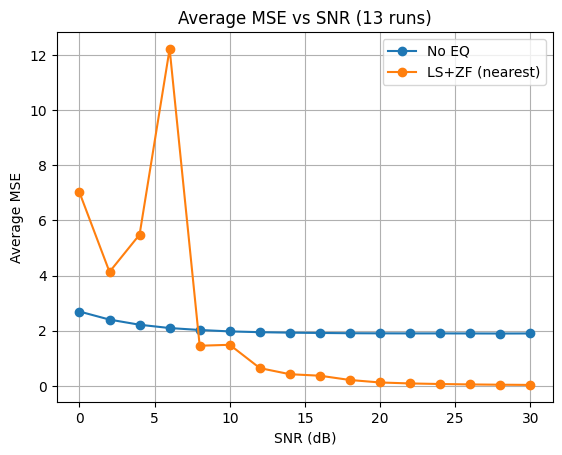

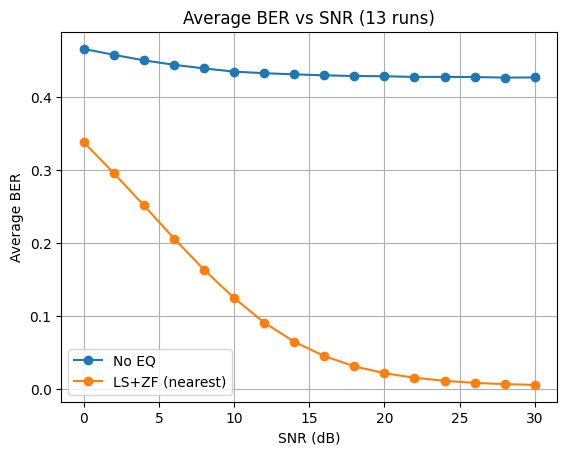

In [18]:
# Plot average MSE
plt.figure()
for m, lab, mk in zip(methods, labels, markers):
    plt.plot(snr_vals, mse_avg[m],
             marker=mk, linestyle='-',
             markevery=1, markersize=6, label=lab)
plt.xlabel('SNR (dB)')
plt.ylabel('Average MSE')
plt.title(f'Average MSE vs SNR ({n_runs} runs)')
plt.legend()
plt.grid(True)

# Plot average BER
plt.figure()
for m, lab, mk in zip(methods, labels, markers):
    plt.plot(snr_vals, ber_avg[m],
             marker=mk, linestyle='-',
             markevery=1, markersize=6, label=lab)
plt.xlabel('SNR (dB)')
plt.ylabel('Average BER')
plt.title(f'Average BER vs SNR ({n_runs} runs)')
plt.legend()
plt.grid(True)

plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# … (your existing imports and ResourceGridBuilder, TDLB100, ls_est_sparse, etc.)

N_SC   = 3276
N_SYM  = 13
DMRS_COL = 3

methods = ['nearest', 'linear', 'average-4', 'average-8', 'average-16', 'average-32']
labels  = ['LS+ZF (nearest)', 'LS+ZF (linear)',
           'LS+ZF (avg 4)', 'LS+ZF (avg 8)',
           'LS+ZF (avg 16)', 'LS+ZF (avg 32)']
snr_vals = np.arange(0, 32, 2)
n_runs   = 13

# Containers
mse_avg     = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}
ber_avg     = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}
mse_chn_avg = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}

def get_true_h_freq(ch):
    x_freq = np.ones((N_SC, N_SYM+1), dtype=np.complex64)   # …14 symbols
    y_time  = ch.apply_channel(ofdm_modulate(x_freq))
    H_true  = ofdm_demodulate(y_time) / x_freq
    return H_true  # shape (3276,14)

for run in range(n_runs):
    for i, snr in enumerate(snr_vals):
        # transmit bits & symbols
        bits_tx    = rg.random_bits()
        symbols_tx = rg.qam16_gray(bits_tx)
        grid_tx    = rg.build_grid(symbols_tx, dmrs_vec)
        tx_slot    = ofdm_modulate(grid_tx)

        # channel + noise
        ch = TDLB100(fs=61.44e6, fd=25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        n = ch.get_noise(y, snr)
        grid_rx = ofdm_demodulate(y + n)

        # true channel
        H_true = get_true_h_freq(ch)

        # data symbols (for BER/MSE of data)
        data_raw = np.delete(grid_rx, DMRS_COL, axis=1)

        for m in methods:
            # 1) Data-domain processing & BER/MSE on symbols
            H_est, _   = ls_est_sparse(grid_rx, dmrs_vec, method=m)
            data_proc  = zf_eq(grid_rx, H_est)
            mse_avg[m][i]     += compute_mse(symbols_tx, data_proc)
            bits_rx           = rg.qam16_gray_demod(data_proc)
            ber_avg[m][i]     += compute_ber(bits_tx, bits_rx)

            # 2) Channel-estimation MSE
            mse_chn_avg[m][i] += np.mean(np.abs(H_est[:,None] - H_true)**2)

# average over runs
for m in methods:
    mse_avg[m]     /= n_runs
    ber_avg[m]     /= n_runs
    mse_chn_avg[m] /= n_runs


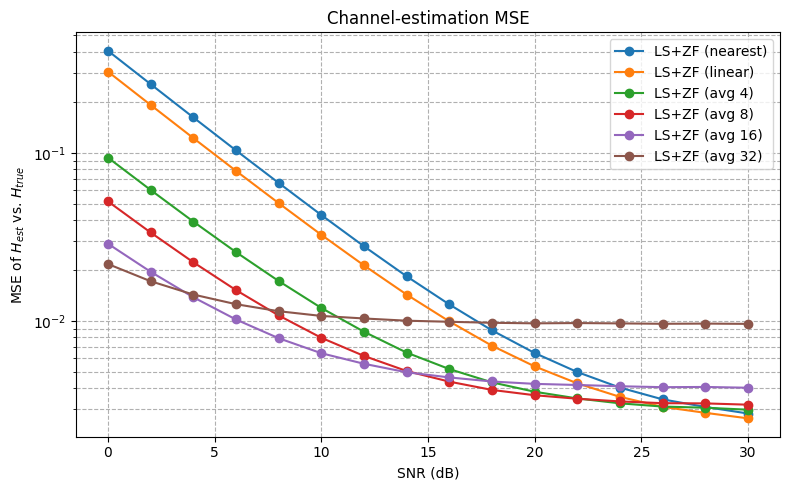

In [20]:
# --- Plot the Channel-estimation MSE curves ---
plt.figure(figsize=(8,5))
for m, lbl in zip(methods, labels):
    plt.semilogy(snr_vals, mse_chn_avg[m], marker='o', label=lbl)

plt.xlabel('SNR (dB)')
plt.ylabel('MSE of $H_{est}$ vs. $H_{true}$')
plt.title('Channel-estimation MSE')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

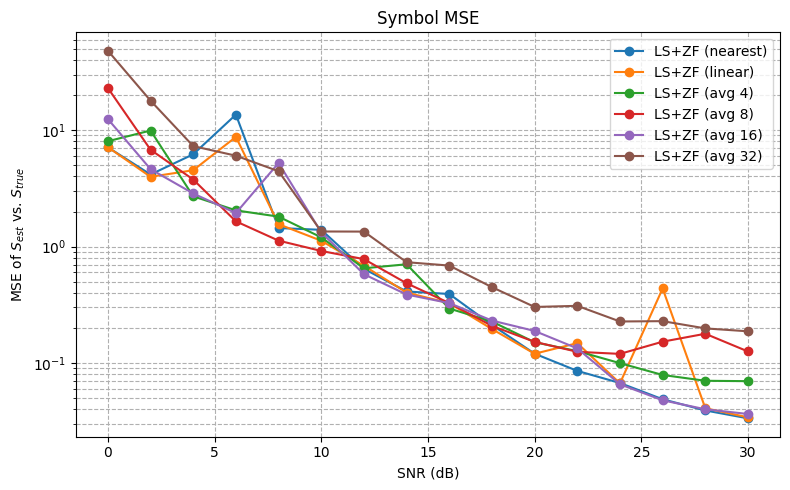

In [21]:
# --- Plot the Symbol MSE curves ---
plt.figure(figsize=(8,5))
for m, lbl in zip(methods, labels):
    plt.semilogy(snr_vals, mse_avg[m], marker='o', label=lbl)

plt.xlabel('SNR (dB)')
plt.ylabel('MSE of $S_{est}$ vs. $S_{true}$')
plt.title('Symbol MSE')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

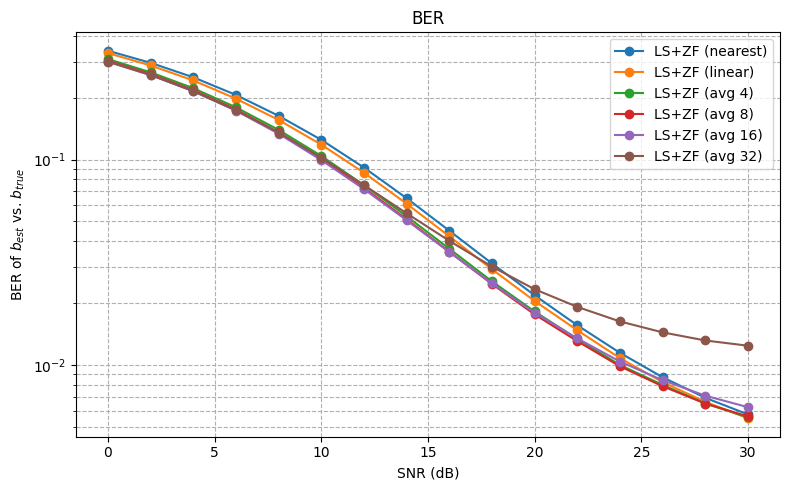

In [22]:
# --- Plot the BER curves ---
plt.figure(figsize=(8,5))
for m, lbl in zip(methods, labels):
    plt.semilogy(snr_vals, ber_avg[m], marker='o', label=lbl)

plt.xlabel('SNR (dB)')
plt.ylabel('BER of $b_{est}$ vs. $b_{true}$')
plt.title('BER')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

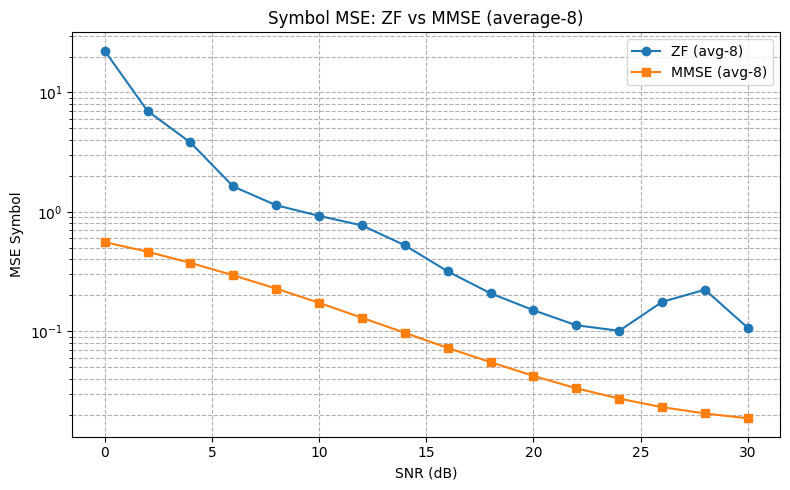

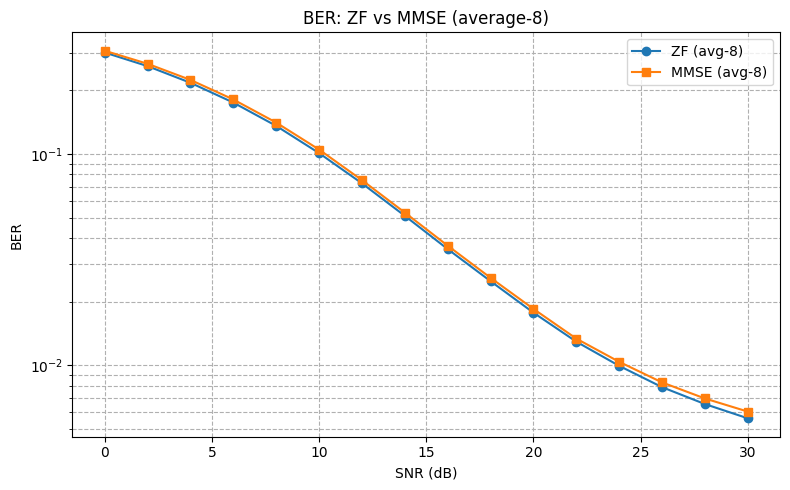

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# … (giữ nguyên import, định nghĩa ofdm_modulate, ofdm_demodulate, rg, dmrs_vec, TDLB100, ls_est_sparse, compute_mse, compute_ber)

methods = ['average-8']        # Chỉ quan tâm method này
snr_vals = np.arange(0, 32, 2)
n_runs   = 13

# Containers cho ZF và MMSE
mse_zf  = np.zeros_like(snr_vals, dtype=float)
ber_zf  = np.zeros_like(snr_vals, dtype=float)
mse_mmse = np.zeros_like(snr_vals, dtype=float)
ber_mmse = np.zeros_like(snr_vals, dtype=float)

for run in range(n_runs):
    for i, snr in enumerate(snr_vals):
        # --- Tx side ---
        bits_tx    = rg.random_bits()
        symbols_tx = rg.qam16_gray(bits_tx)
        grid_tx    = rg.build_grid(symbols_tx, dmrs_vec)
        tx_slot    = ofdm_modulate(grid_tx)

        # --- Channel + noise ---
        ch = TDLB100(fs=61.44e6, fd=25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        n = ch.get_noise(y, snr)
        grid_rx = ofdm_demodulate(y + n)

        # --- LS estimation (average-8) ---
        H_est, noise_var = ls_est_sparse(grid_rx, dmrs_vec, method='average-8')

        # --- ZF equalization ---
        data_zf = zf_eq(grid_rx, H_est, dmrs_col=DMRS_COL)
        mse_zf[i] += compute_mse(symbols_tx, data_zf)
        bits_zf   = rg.qam16_gray_demod(data_zf)
        ber_zf[i] += compute_ber(bits_tx, bits_zf)

        # --- MMSE equalization ---
        data_mmse = mmse_eq(grid_rx, H_est, noise_var, dmrs_col=DMRS_COL)
        mse_mmse[i] += compute_mse(symbols_tx, data_mmse)
        bits_mmse   = rg.qam16_gray_demod(data_mmse)
        ber_mmse[i] += compute_ber(bits_tx, bits_mmse)

# Trung bình qua các run
mse_zf  /= n_runs
ber_zf  /= n_runs
mse_mmse /= n_runs
ber_mmse /= n_runs

# Vẽ so sánh MSE
plt.figure(figsize=(8,5))
plt.semilogy(snr_vals, mse_zf,   marker='o', label='ZF (avg-8)')
plt.semilogy(snr_vals, mse_mmse,  marker='s', label='MMSE (avg-8)')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE Symbol')
plt.title('Symbol MSE: ZF vs MMSE (average-8)')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()

# Vẽ so sánh BER
plt.figure(figsize=(8,5))
plt.semilogy(snr_vals, ber_zf,   marker='o', label='ZF (avg-8)')
plt.semilogy(snr_vals, ber_mmse,  marker='s', label='MMSE (avg-8)')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER: ZF vs MMSE (average-8)')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()

plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# … (your existing imports and ResourceGridBuilder, TDLB100, ls_est_sparse, etc.)

N_SC   = 3276
N_SYM  = 13
DMRS_COL = 3

methods = ['nearest', 'average-8', 'wiener1step', 'wiener2step']
labels  = ['LS+ZF (nearest)', 'LS+ZF (avg 8)', 'LS+ZF (wiener1step)', 'LS+ZF (wiener2step)']
snr_vals = np.arange(0, 32, 2)
n_runs   = 13

# Containers
mse_avg     = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}
ber_avg     = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}
mse_chn_avg = {m: np.zeros_like(snr_vals, dtype=float) for m in methods}

def get_true_h_freq(ch):
    x_freq = np.ones((N_SC, N_SYM+1), dtype=np.complex64)   # …14 symbols
    y_time  = ch.apply_channel(ofdm_modulate(x_freq))
    H_true  = ofdm_demodulate(y_time) / x_freq
    return H_true  # shape (3276,14)

for run in range(n_runs):
    for i, snr in enumerate(snr_vals):
        # transmit bits & symbols
        bits_tx    = rg.random_bits()
        symbols_tx = rg.qam16_gray(bits_tx)
        grid_tx    = rg.build_grid(symbols_tx, dmrs_vec)
        tx_slot    = ofdm_modulate(grid_tx)

        # channel + noise
        ch = TDLB100(fs=61.44e6, fd=25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        n = ch.get_noise(y, snr)
        grid_rx = ofdm_demodulate(y + n)

        # true channel
        H_true = get_true_h_freq(ch)

        # data symbols (for BER/MSE of data)
        data_raw = np.delete(grid_rx, DMRS_COL, axis=1)

        for m in methods:
            # 1) Data-domain processing & BER/MSE on symbols
            H_est, _   = ls_est_sparse(grid_rx, dmrs_vec, method=m)
            data_proc  = zf_eq(grid_rx, H_est)
            mse_avg[m][i]     += compute_mse(symbols_tx, data_proc)
            bits_rx           = rg.qam16_gray_demod(data_proc)
            ber_avg[m][i]     += compute_ber(bits_tx, bits_rx)

            # 2) Channel-estimation MSE
            mse_chn_avg[m][i] += np.mean(np.abs(H_est[:,None] - H_true)**2)

# average over runs
for m in methods:
    mse_avg[m]     /= n_runs
    ber_avg[m]     /= n_runs
    mse_chn_avg[m] /= n_runs


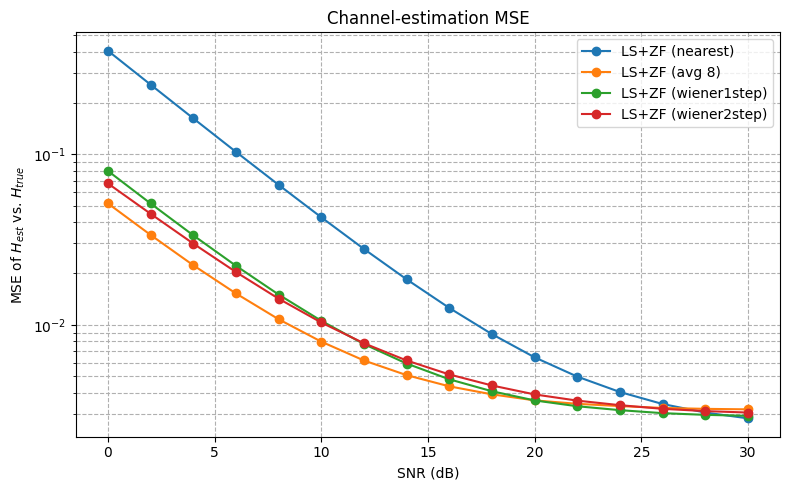

In [25]:
# --- Plot the Channel-estimation MSE curves ---
plt.figure(figsize=(8,5))
for m, lbl in zip(methods, labels):
    plt.semilogy(snr_vals, mse_chn_avg[m], marker='o', label=lbl)

plt.xlabel('SNR (dB)')
plt.ylabel('MSE of $H_{est}$ vs. $H_{true}$')
plt.title('Channel-estimation MSE')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

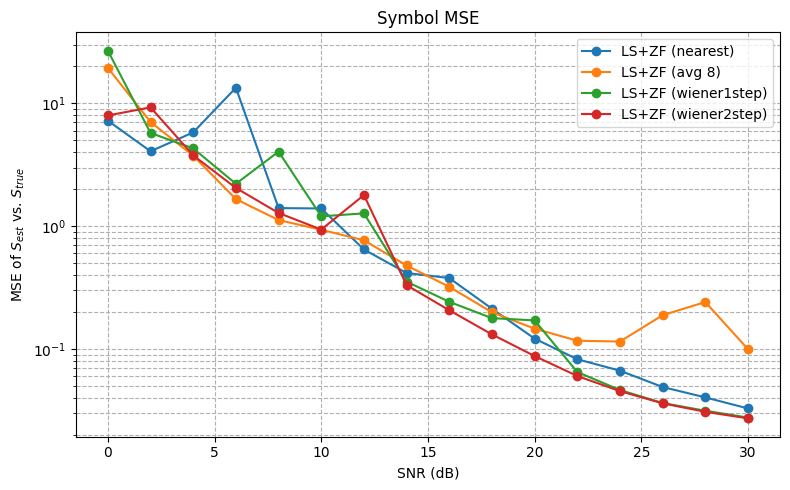

In [26]:
# --- Plot the Symbol MSE curves ---
plt.figure(figsize=(8,5))
for m, lbl in zip(methods, labels):
    plt.semilogy(snr_vals, mse_avg[m], marker='o', label=lbl)

plt.xlabel('SNR (dB)')
plt.ylabel('MSE of $S_{est}$ vs. $S_{true}$')
plt.title('Symbol MSE')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

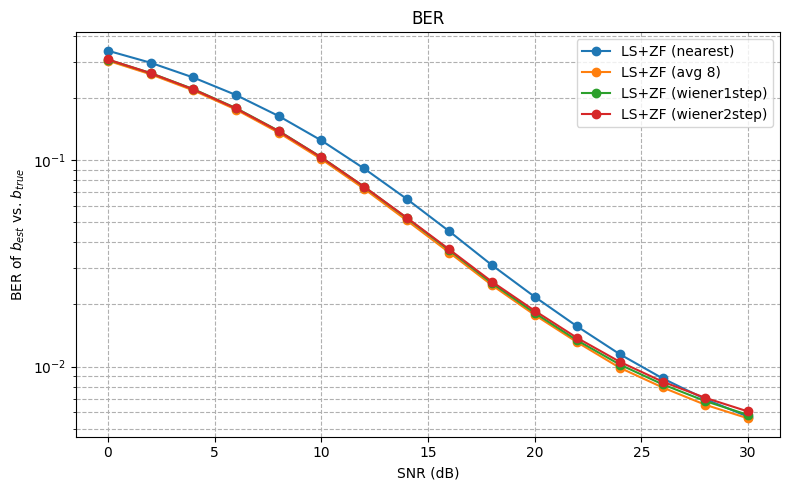

In [27]:
# --- Plot the BER curves ---
plt.figure(figsize=(8,5))
for m, lbl in zip(methods, labels):
    plt.semilogy(snr_vals, ber_avg[m], marker='o', label=lbl)

plt.xlabel('SNR (dB)')
plt.ylabel('BER of $b_{est}$ vs. $b_{true}$')
plt.title('BER')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# … (giữ nguyên import, định nghĩa ofdm_modulate, ofdm_demodulate, rg, dmrs_vec, TDLB100, ls_est_sparse, compute_mse, compute_ber)

methods = ['average-8']        # Chỉ quan tâm method này
snr_vals = np.arange(0, 32, 2)
n_runs   = 13

# Containers cho ZF và MMSE
mse_zf_qpsk  = np.zeros_like(snr_vals, dtype=float)
ber_zf_qpsk  = np.zeros_like(snr_vals, dtype=float)

for run in range(n_runs):
    for i, snr in enumerate(snr_vals):
        # --- Tx side ---
        bits_tx    = rg.random_bits(2)
        symbols_tx = rg.qpsk(bits_tx)
        grid_tx    = rg.build_grid(symbols_tx, dmrs_vec)
        tx_slot    = ofdm_modulate(grid_tx)

        # --- Channel + noise ---
        ch = TDLB100(fs=61.44e6, fd=25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        n = ch.get_noise(y, snr)
        grid_rx = ofdm_demodulate(y + n)

        # --- LS estimation (average-8) ---
        H_est, noise_var = ls_est_sparse(grid_rx, dmrs_vec, method='average-8')

        # --- ZF equalization ---
        data_zf = zf_eq(grid_rx, H_est, dmrs_col=DMRS_COL)
        mse_zf_qpsk[i] += compute_mse(symbols_tx, data_zf)
        bits_zf   = rg.qpsk_demod(data_zf)
        ber_zf_qpsk[i] += compute_ber(bits_tx, bits_zf)

# Trung bình qua các run
mse_zf_qpsk  /= n_runs
ber_zf_qpsk  /= n_runs

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# … (giữ nguyên import, định nghĩa ofdm_modulate, ofdm_demodulate, rg, dmrs_vec, TDLB100, ls_est_sparse, compute_mse, compute_ber)

methods = ['average-8']        # Chỉ quan tâm method này
snr_vals = np.arange(0, 32, 2)
n_runs   = 13

# Containers cho ZF và MMSE
mse_zf_16qam  = np.zeros_like(snr_vals, dtype=float)
ber_zf_16qam  = np.zeros_like(snr_vals, dtype=float)

for run in range(n_runs):
    for i, snr in enumerate(snr_vals):
        # --- Tx side ---
        bits_tx    = rg.random_bits(6)
        symbols_tx = rg.qam64_gray(bits_tx)
        grid_tx    = rg.build_grid(symbols_tx, dmrs_vec)
        tx_slot    = ofdm_modulate(grid_tx)

        # --- Channel + noise ---
        ch = TDLB100(fs=61.44e6, fd=25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        n = ch.get_noise(y, snr)
        grid_rx = ofdm_demodulate(y + n)

        # --- LS estimation (average-8) ---
        H_est, noise_var = ls_est_sparse(grid_rx, dmrs_vec, method='average-8')

        # --- ZF equalization ---
        data_zf = zf_eq(grid_rx, H_est, dmrs_col=DMRS_COL)
        mse_zf_16qam[i] += compute_mse(symbols_tx, data_zf)
        bits_zf   = rg.qam64_gray_demod(data_zf)
        ber_zf_16qam[i] += compute_ber(bits_tx, bits_zf)



In [36]:
import numpy as np
import matplotlib.pyplot as plt

# … (giữ nguyên import, định nghĩa ofdm_modulate, ofdm_demodulate, rg, dmrs_vec, TDLB100, ls_est_sparse, compute_mse, compute_ber)

methods = ['average-8']        # Chỉ quan tâm method này
snr_vals = np.arange(0, 32, 2)
n_runs   = 13

# Containers cho ZF và MMSE
mse_zf_64qam  = np.zeros_like(snr_vals, dtype=float)
ber_zf_64qam  = np.zeros_like(snr_vals, dtype=float)

for run in range(n_runs):
    for i, snr in enumerate(snr_vals):
        # --- Tx side ---
        bits_tx    = rg.random_bits(6)
        symbols_tx = rg.qam64_gray(bits_tx)
        grid_tx    = rg.build_grid(symbols_tx, dmrs_vec)
        tx_slot    = ofdm_modulate(grid_tx)

        # --- Channel + noise ---
        ch = TDLB100(fs=61.44e6, fd=25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        n = ch.get_noise(y, snr)
        grid_rx = ofdm_demodulate(y + n)

        # --- LS estimation (average-8) ---
        H_est, noise_var = ls_est_sparse(grid_rx, dmrs_vec, method='average-8')

        # --- ZF equalization ---
        data_zf = zf_eq(grid_rx, H_est, dmrs_col=DMRS_COL)
        mse_zf_64qam[i] += compute_mse(symbols_tx, data_zf)
        bits_zf   = rg.qam64_gray_demod(data_zf)
        ber_zf_64qam[i] += compute_ber(bits_tx, bits_zf)



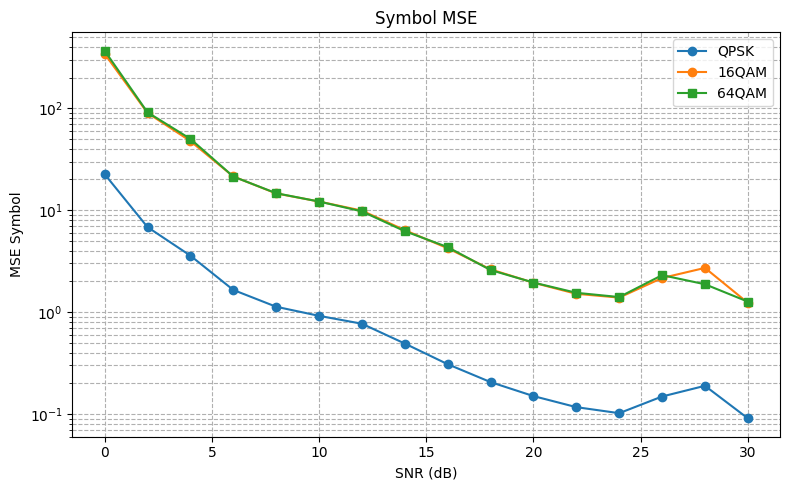

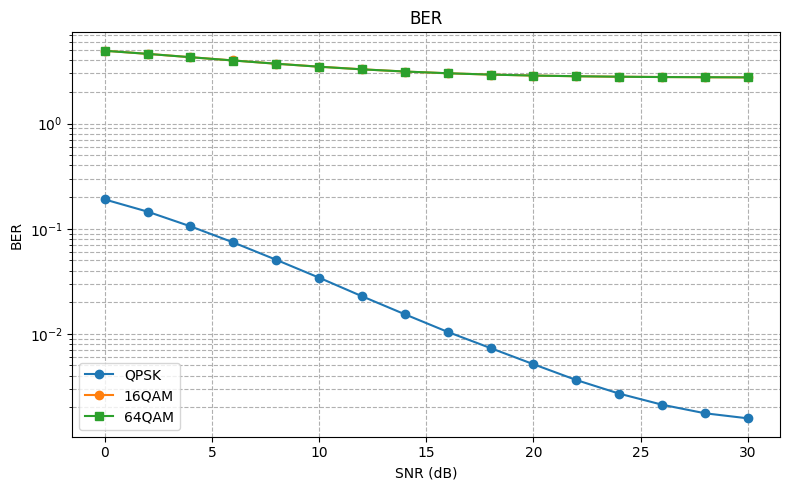

In [37]:
# Vẽ so sánh MSE
plt.figure(figsize=(8,5))
plt.semilogy(snr_vals, mse_zf_qpsk, marker='o', label='QPSK')
plt.semilogy(snr_vals, mse_zf_16qam, marker='o', label='16QAM')
plt.semilogy(snr_vals, mse_zf_64qam, marker='s', label='64QAM')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE Symbol')
plt.title('Symbol MSE')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()

# Vẽ so sánh BER
plt.figure(figsize=(8,5))
plt.semilogy(snr_vals, ber_zf_qpsk, marker='o', label='QPSK')
plt.semilogy(snr_vals, ber_zf_16qam, marker='o', label='16QAM')
plt.semilogy(snr_vals, ber_zf_64qam, marker='s', label='64QAM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('BER')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()

plt.show()
